In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import copy

In [2]:
def next_u(u_prev):
    noise = np.random.normal(0, 0.5, 1)
    return 0.9 * u_prev + noise

def curr_y(u):
    noise = np.random.normal(0, 0.1, 1)
    return 1.3 * u + noise

def gen_process(n = 2000):

    # Initial State
    u_0 = np.random.normal(0,1,1)

    # Initialize storage
    u = [u_0]
    y = []

    for i in range(n):
        u_prev = u[i]
        u.append(next_u(u_prev))
        y.append(curr_y(u_prev))

    y.append(curr_y(u[-1]))

    iters = [i for i in range(len(y))]

    return iters, u, y


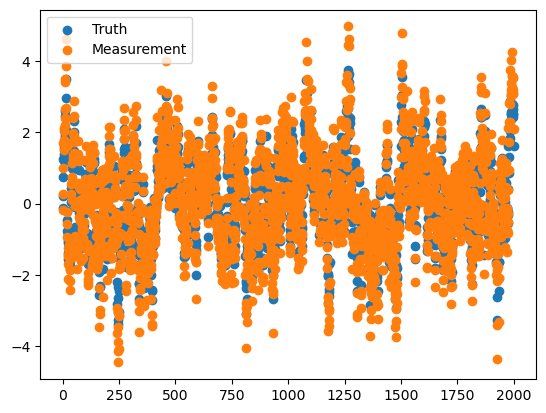

In [3]:
iters, u, y = gen_process()


plt.scatter(iters, u, label = "Truth")
plt.scatter(iters, y, label = "Measurement")
plt.legend()

In [4]:
class Kalman:

    def __init__(self):
        self.A = 0.9
        self.C = 0.5
        self.H = 1.3
        self.T = 0.1

        self.var = 1
        self.var_pred = 0
        self.u_pred = None
        self.u_prev_est = np.random.normal(0,1,1)
        self.u_est_hist = [self.u_prev_est]

    def predict(self):
        u_pred = self.A * self.u_prev_est
        self.u_pred = u_pred

        self.var_pred = self.var * self.A + self.C 
        
        return u_pred
    
    def analyse(self, y_meas):
        d = y_meas - self.H * self.u_pred
        S = self.H * self.var_pred * self.H + self.T
        K = self.var_pred * self.H * (1/S)

        u_pred_analysis = self.u_pred + K * d
        self.var = self.A * self.var_pred * self.A + self.C

        self.update(u_pred_analysis)

        return u_pred_analysis
    
    def update(self, new_u_est):
        self.u_est_hist.append(new_u_est)
        self.u_prev_est = new_u_est


class Naive():

    def __init__(self):
        self.H = 1.3

    def predict(self, y_meas):
        return y_meas/self.H
    
def RMSE(pred, target):

    pred = np.array(pred)
    target = np.array(target)

    return np.sqrt(np.mean((pred - target)**2))

RMSE Naive: 0.0794
RMSE Kalman: 0.0790


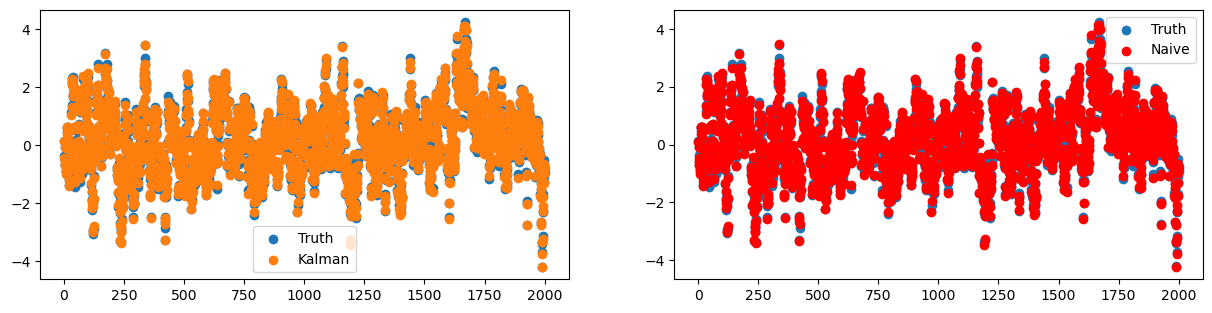

In [5]:
iters, u, y = gen_process()

Kalman_filter = Kalman()
naive_predictor = Naive()

Kalman_states = []
Naive_states = []

for i in range(1,len(iters)):

    Kalman_filter.predict()
    u_pred_analysis = Kalman_filter.analyse(y[i])
    u_naive = naive_predictor.predict(y[i])

    Kalman_states.append(u_pred_analysis)
    Naive_states.append(u_naive)

print(f"RMSE Naive: {RMSE(Naive_states, u[1:]):.4f}")
print(f"RMSE Kalman: {RMSE(Kalman_states, u[1:]):.4f}")

fig, axes = plt.subplots(1,2, figsize = (15,3.5))

axes[0].scatter(iters[1:], u[1:], label = "Truth")
axes[1].scatter(iters[1:], u[1:], label = "Truth")

axes[0].scatter(iters[1:], Kalman_states, label = "Kalman")
axes[1].scatter(iters[1:], Naive_states, label = "Naive", color = 'red')

axes[0].legend()
axes[1].legend()

In [9]:
class Particle():
    def __init__(self, mu = 0, var = 1, u_prev_est = None):
        self.A = 0.9
        self.C = 0.5
        self.H = 1.3
        self.T = 0.1

        self.var = var
        self.var_pred = 0
        self.u_pred = None

        if u_prev_est is None:
            self.u_prev_est = np.random.normal(mu, var,1)
        else:
            self.u_prev_est = u_prev_est
        
        self.u_est_hist = [self.u_prev_est]

    def predict(self):
        u_pred = next_u(self.u_prev_est)
        self.u_pred = u_pred
        
        return u_pred
    
    def update(self, new_u_est):
        self.u_est_hist.append(new_u_est)
        self.u_prev_est = new_u_est

    
class Kalman_Ensemble():

    def __init__(self, n):
        self.n = n
        self.parts = []
        u_estimates = []
        self.weights = np.ones(self.n)/self.n
        self.expect = 0
        self.iters = 0

        for i in range(n):
            self.parts.append(Particle())
            u_estimates.append(self.parts[i].u_prev_est)

        self.u_est = np.array(u_estimates).mean()
        self.u_est_hist = []

    def predict(self):
        for i in range(self.n):
            self.parts[i].predict()

    def analyse(self, y_measure, u_true):
        y_meas  = [curr_y(self.parts[i].u_pred) for i in range(self.n)]
        u_preds = [self.parts[i].u_pred for i in range(self.n)]
        
        I = np.identity(self.n)
        sub_matrix = I - 1/self.n * np.ones((self.n, self.n))
        
        Y = np.array(y_meas).reshape(1,self.n) @ sub_matrix
        U = np.array(u_preds).reshape(1,self.n) @ sub_matrix

        K = ((U @ Y.T) / (Y @ Y.T))[0][0]

        u_estimates = []

        for i in range(self.n):
            u_est = (self.parts[i].u_pred + K * (y_measure - y_meas[i]))[0]
            self.parts[i].update(u_est)
            u_estimates.append(u_est)

        new_u_est = np.array(u_estimates).mean()

        if u_true is not None:
            self.expect += (self.weights * (u_estimates - u_true)**2).sum()

        self.update(new_u_est)
        return new_u_est

    def update(self, new_u_est):
        self.iters += 1
        self.u_est_hist.append(new_u_est)
        self.u_est = new_u_est

    def iterate(self, y_meas, u_true = None):
        self.predict()
        self.analyse(y_meas, u_true)

    def RMSE(self):
        return self.expect/self.iters


In [18]:
import time

class Bootstrap_PT:
    def __init__(self, n):
        self.n = n
        self.u_est = None
        self.u_est_hist = []
        self.expect = 0
        self.parts = None
        self.weights = None
        self.iters = 0
        self.ESS_hist = []

    def resample(self):

        if self.parts is None:
            self.parts = np.random.normal(0, 1, self.n)
            self.weights = np.ones(self.n)/self.n
        else:
            self.parts = np.random.choice(self.parts, size=self.n, p=self.weights)

        self.ESS_hist.append(1 / (self.n * (self.weights**2).sum()))
        

    def predict(self):
        noise = np.random.normal(0, 0.5, self.n)
        self.parts = self.parts * 0.9 + noise

    def analyse(self, y_meas, u_true):
        estimates = self.parts

        likelihoods = norm(1.3 * estimates, 0.1).pdf(y_meas)

        self.weights = likelihoods / np.sum(likelihoods)

        # Compute weighted estimate
        u_est_b = np.dot(self.weights, estimates)
        self.update(u_est_b)

        if u_true is not None:
            self.expect += (self.weights * (estimates - u_true)**2).sum()

        return u_est_b

    def update(self, u_est_b):
        self.u_est_hist.append(u_est_b)
        self.u_est = u_est_b

    def iterate(self,y_meas, u_true = None):
        self.iters += 1
        self.resample()
        self.predict()
        self.analyse(y_meas, u_true)

    def RMSE(self):
        return self.expect/self.iters


RMSE Kalman Ensemble: 0.0118
RMSE Bootstrap: 0.0382


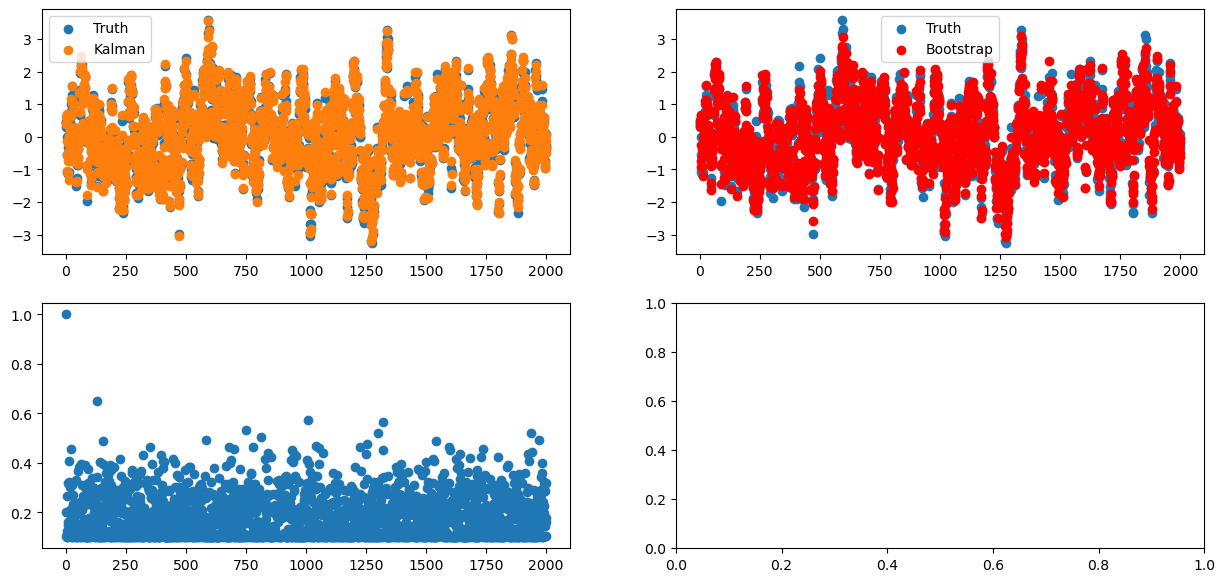

In [19]:
iters, u, y = gen_process(2000)

bootstrap = Bootstrap_PT(n = 10)
Kalman_ensemble_filter = Kalman_Ensemble(10)


for i in range(1,len(iters)):

    Kalman_ensemble_filter.iterate(y[i], u[i])
    bootstrap.iterate(y[i], u[i])


print(f"RMSE Kalman Ensemble: {Kalman_ensemble_filter.RMSE():.4f}")
print(f"RMSE Bootstrap: {bootstrap.RMSE():.4f}")

fig, axes = plt.subplots(2,2, figsize = (15,7))

axes[0][0].scatter(iters[1:], u[1:], label = "Truth")
axes[0][1].scatter(iters[1:], u[1:], label = "Truth")

axes[0][0].scatter(iters[1:], Kalman_ensemble_filter.u_est_hist, label = "Kalman")
axes[0][1].scatter(iters[1:], bootstrap.u_est_hist, label = "Bootstrap", color = 'red')

axes[0][0].legend()
axes[0][1].legend()

axes[1][0].scatter(iters[1:], bootstrap.ESS_hist)